<a href="https://colab.research.google.com/github/Nhatkhang/Machine_learning_CBD/blob/Project_assignments/Lung_cancer_project_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

In [1]:
!ls

annotations_luna16.csv	kaggle.json	  luna16-106-files.zip
candidates_V2		LUN_16_106_files  sample_data


In [4]:
!ls -lha kaggle.json
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 76 Jan  5 01:23 kaggle.json


In [5]:
!kaggle datasets download -d nguyenhoangnhatkhang/luna16-106-files

100% 7.21G/7.21G [01:49<00:00, 53.0MB/s]
100% 7.21G/7.21G [01:49<00:00, 70.9MB/s]


In [6]:
!ls

annotations_luna16.csv	kaggle.json  luna16-106-files.zip  sample_data


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/luna16-106-files.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [8]:
!ls

annotations_luna16.csv	kaggle.json	  luna16-106-files.zip
candidates_V2		LUN_16_106_files  sample_data


In [9]:
%cd LUN_16_106_files


/content/LUN_16_106_files


In [0]:
%mv ../LUN_16_106_files/candidates_V2  ../ 

In [0]:
%mv ../LUN_16_106_files/annotations_luna16.csv ../

In [14]:
pip install SimpleITK

     |████████████████████████████████| 42.5MB 98kB/s 


# **LUNG CANCER PROJECT**




Use Deep Learning and this dataset to determine if the patient will be
diagnosed with lung cancer. You are given over a thousand
low-dose CT images from high-risk patients in DICOM format.
Each image contains a series with multiple axial slices of the
chest cavity. Each image has a variable number of 2D slices,
which can vary based on the machine taking the scan and patient.
The DICOM files have a header that contains the necessary
information about the patient id, as well as scan parameters such
as the slice thickness. The project should follow the guideline as:

1. Pre-process the image data
2. Perform data exploration to learn as much about the data (include
visualization in 2D, 3D, segmentation, bisecting images, rotation, etc.)
3. Apply CNN with classification_report to determine the result.
4. Tune the models for better performance.
5. Using Object Localization, locate precisely the location of tumor (if
positive).
6. Identify the correct measurement the size of tumor (in terms of
diameter, thickness, shapes, etc.).
7. Using test images, evaluate the performance of models.

## Introduction
This project aims to create a classifier of cancer for patients based on the DICOM CT scan images. The CNN is used in this report to predict the outcome of high risk patients. Firstly, we will describe the image data in the **Data exploration** section. After that, the CNN model will be constructed and train to fit our data in **CNN model** section. An evaluation of the model will be presented latter. 

## Data Exploration

In [0]:
import SimpleITK as sitk
import csv
import os
from PIL import Image
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi

We define now a function to open the image, store it into a numpy array and extract the some info:
- Origin
- Pixel Spacing

In [0]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

We will take the list of the patient as follow:

In [4]:
INPUT_FOLDER = '/content/LUN_16_106_files/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
print(len(patients))
# 106 files mhd

106


Let 's check 

In [0]:
ran_patient= INPUT_FOLDER+patients[10]+'/'+patients[10]

In [7]:
numpyImage, numpyOrigin, numpySpacing = load_itk_image(ran_patient)
print (numpyImage.shape)
print (numpyOrigin)
print (numpySpacing)

(143, 512, 512)
[-394.5 -220.  -199.3]
[2.5      0.859375 0.859375]


For the 10th patient, he got 143 slices of his lung CT scan

Let's see first image of a CT scan of 25 first patients

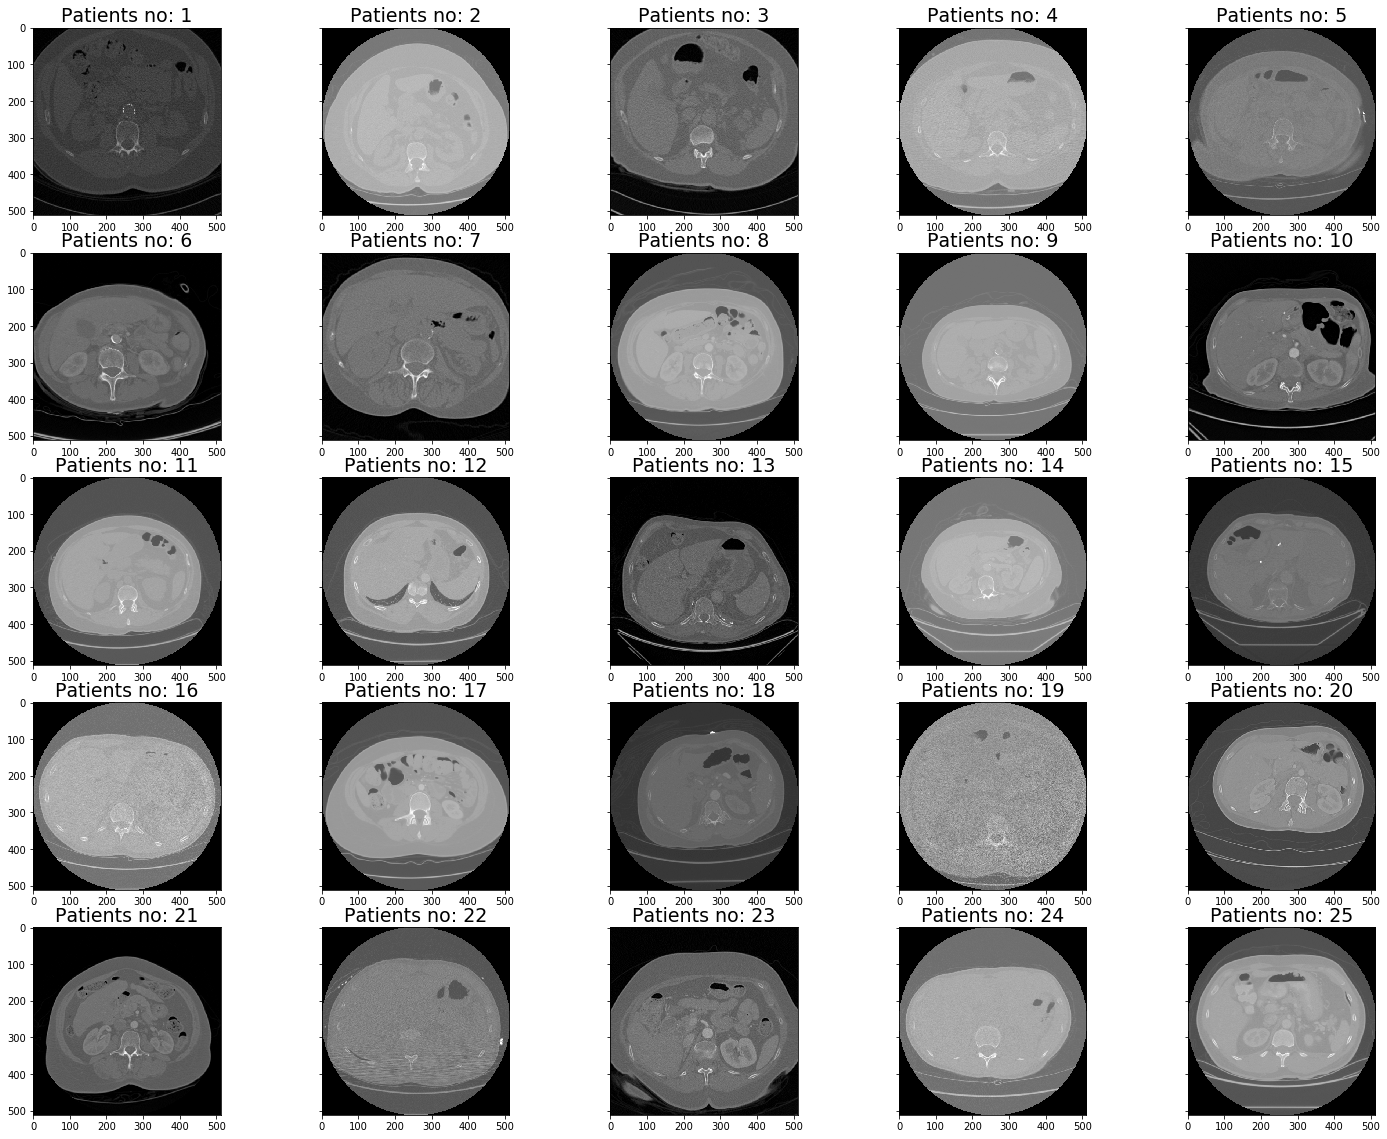

In [19]:
fig, axs = plt.subplots(5,5, figsize=(25, 20), sharey='row')
axs = axs.ravel()
for index, i in enumerate(range(0,25)):
    axs[index].imshow(load_itk_image(INPUT_FOLDER+patients[i]+'/'+patients[i])[0][0],cmap=plt.cm.gray)
    axs[index].set_title('Patients no: '+str(i+1),fontsize=19)
plt.show()


In [0]:
# plot functions
def plot_2d(image,slice_step=5,col=4):   
    slice_per_row = slice_step * col
    row = int(image.shape[0]/slice_per_row)+1 # round up
    f, plots = plt.subplots(row, col, figsize=(20, 15))
    for i in range(0, image.shape[0], slice_step):
        plots[int(i / slice_per_row), int((i / slice_step) % col)].imshow(image[i], cmap=plt.cm.gray)
    for r in range(row):
        for c in range(col):
            plots[r, c].axis('off')
def plot_3d(image, floor=-700):
    # Floor: lowest DU that will be visible
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, floor)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()
def resample(image, old_spacing, new_spacing=[1,1,1]):
    """
    Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    Parameters
    ----------
    image: numpy ndarray
    old_spacing: spacing of @image before scaled
    new_spacing: spacing of @image after scaled
    Return
    ------
    image: new scaled numpy array image
    new_spacing: can be different from the new_spacing in input
    """
    spacing = old_spacing
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    
    image = ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    new_spacing = spacing / real_resize_factor
    
    return image, new_spacing

Above function is to reshape the image into a uniform format and ploting a serie of slice for one patient. Let's take a look for the 10th patient

In [15]:
# rni: resampled numpy image
img, spacing = resample(numpyImage, numpySpacing, [1,1,1])
print("Shape before resampling\t", numpyImage.shape)
print("Shape after resampling\t", img.shape)

Shape before resampling	 (143, 512, 512)
Shape after resampling	 (358, 440, 440)


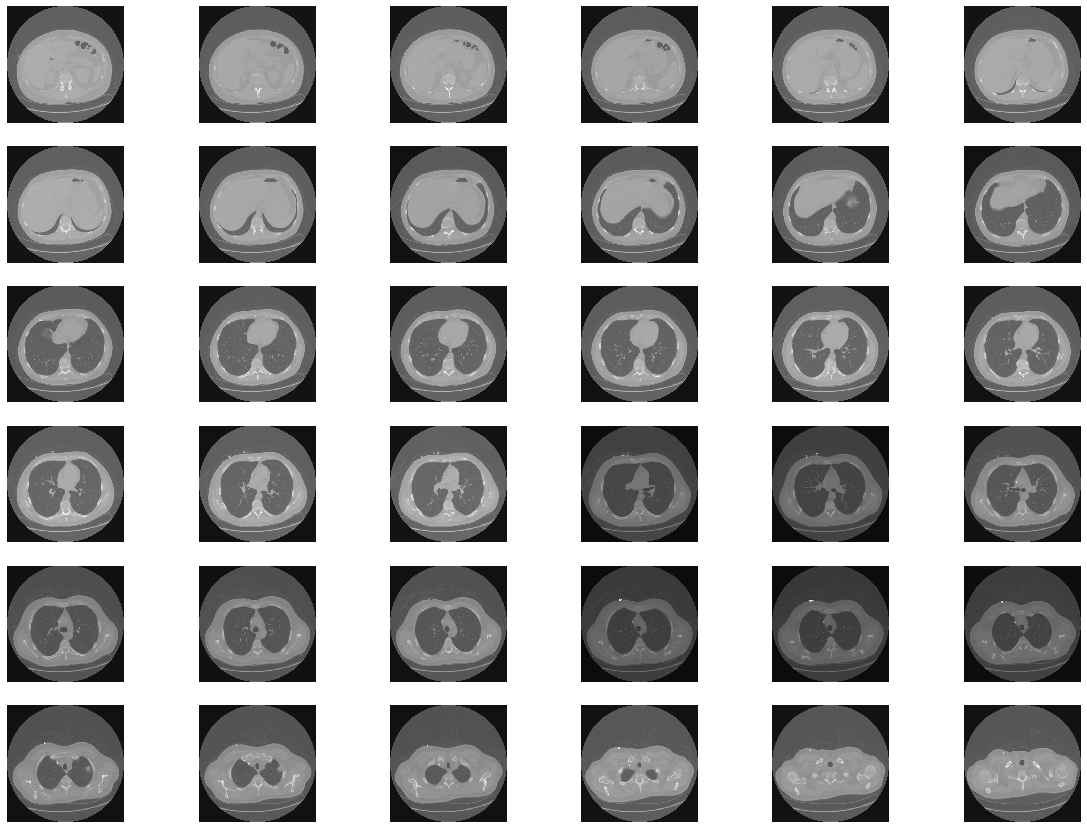

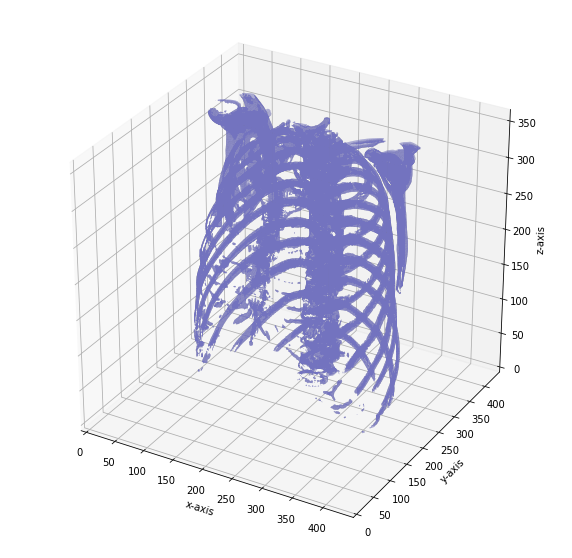

In [17]:
plot_2d(img,slice_step=10,col=6)
plot_3d(img,400)
plt.show()

[1] https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/comments